# Soil food web interactive analysis and visualization 

This notebook implements our approach to interactive analysis and visualization of soil food webs using Jupyter notebooks and interactive IPython widgets. Therefore, it does not require programming skills beyond setting parameter values and running parts of the notebook. ... BLABLA

## Part 1: preparing the environment and loading the data

In the very first part of the notebook all the required modules and libraries are imported and few helper functions are defined. Next, a data file containing the soil food network in the form of a `NxN` 0/1 matrix is loaded using the widget which allows uploading a file to the memory. Currently, `.csv` files are supported. The matrix is also displayed inline to ensure that the data was loaded correctly.

In [298]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [299]:
import importlib
import io
import codecs
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from pyvis.network import Network as net

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual,  HBox, VBox
from IPython.display import display, HTML

from utils.ui_functions import alert, StopExecution, make_download_button
from utils.conf import my_style, my_layout

alert_user = lambda message: display(HTML(alert(message)))

### 1.1 Loading the network matrix

In [300]:
# ***Development code***
# Create a pandas df from csv
sfw_matrix = pd.read_csv("data/matrice Marko-4_Martin.csv", header=0, index_col=0, sep=";")
#pd.set_option("max_columns", None)
#sfw_matrix

In [301]:
# widgets.FileUpload(accept='.csv',multiple=False)
# matrix_uploader = widgets.FileUpload()
# display(matrix_uploader)

In [302]:
# try:
#     matrix_file_name, matrix_file_data = list(matrix_uploader.value.items())[0]
# except Exception:
#     alert_user('Please load the food web matrix data file the cell above!\nThe program cannot continue without this data.')
#     raise StopExecution    
# sfw_matrix = pd.read_csv(io.StringIO(codecs.decode(matrix_file_data['content'], encoding="utf-8")),
#                          header=0, 
#                          index_col=0, 
#                          sep=";")

# if sfw_matrix.shape[0]!=sfw_matrix.shape[1]:
#     alert_user('Invalid graph matrix: it must have NxN shape.')
#     raise StopExecution

# @interact(nrows=widgets.IntSlider(description='Rows:', min=3, max=sfw_matrix.shape[1], step=1, value=5),
#           ncols=widgets.IntSlider(description='Columns:', min=3, max=sfw_matrix.shape[0], step=1, value=10))
# def show_soil_food_web_matrix(nrows, ncols):
#     pd.set_option("display.max_rows", nrows)
#     pd.set_option("display.max_columns", ncols)
#     display(sfw_matrix)

### 1.2 Loading the trophic level matrix

If we have the trophic level data it is possible to load it here. It must have the `Nx1` shape. If no such data is available, the following two cells are skipped and the trophic level will not be used (all nodes will have the same value).

In [303]:
# ***Development code***
# Import trophic levels
trophic_levels = pd.read_csv("data/trophic_levels_1_0.csv", index_col=0, header=None, delimiter=";", names=["trophic_level"])
trophic_levels = trophic_levels.squeeze()

# Create dict from trophic level Series
troph_lev_dict = trophic_levels.to_dict()
#troph_lev_dict

In [304]:
# widgets.FileUpload(accept='csv',multiple=False)
# trophic_level_uploader = widgets.FileUpload()
# display(trophic_level_uploader)

In [305]:
# try:
#     trophic_level_file_name, trophic_level_file_data = list(trophic_level_uploader.value.items())[0]
# except Exception:
#     alert_user('Please load the file with trophic level data in the cell above!\nThe program cannot continue without trophic level data.')
#     raise StopExecution
# trophic_levels = pd.read_csv(io.StringIO(codecs.decode(trophic_level_file_data['content'], encoding='utf-8')),
#                              index_col=0, header=None, delimiter=";", names=['trophic_level'])

# if trophic_levels.shape[1]!=1:
#     alert_user('Invalid thropic matrix: it must have Nx1 shape.')
#     raise StopExecution
# if trophic_levels.shape[0] != sfw_matrix.shape[0]:
#     alert_user('Invalid number of rows in the trophic matrix: trophic level must be defined for all organisms (nodes).')
#     raise StopExecution
    
# pd.set_option('display.max_rows', None)
# display(trophic_levels.sort_values('trophic_level'))
# trophic_levels = trophic_levels.squeeze()
# trophic_levels_dict = trophic_levels.to_dict()

## Part 2: Network construction and manipulation

### 2.1 Network construction

Using the provided adjacency matrix data and the trophic level data we will create the network structure and offer basic editing functions. 

In [306]:
G = nx.from_pandas_adjacency(sfw_matrix, create_using=nx.DiGraph)
# remove default edge weights
for n1, n2, d in G.edges(data=True):
    d.clear()
    
graph_name_input = widgets.Text(placeholder='The name of this network', value='My network', description='Name:', disabled=False, style=my_style)
rename_button = widgets.Button(description='Rename', disabled=False, button_style='primary',icon='edit')
rename_log = widgets.Output(layout={'border': '1px solid blue'})
display(rename_log)
def rename_graph(widget_name):
    G.name = graph_name_input.value
    rename_log.clear_output()
    rename_log.append_display_data(f'Graph renamed to "{G.name}"')
rename_button.on_click(rename_graph)

# TODO make sure the network has a name
HBox([graph_name_input, rename_button])

Output(layout=Layout(border='1px solid blue'))

In [308]:
if not G.name:
    alert_user('The network does not have a name!\nPlease use the "Rename" button in the above cell.')
    raise StopExecution

print('--- Basic network info ---')
print(f'Name: {G.name}')
typ = 'directed' if nx.is_directed(G) else 'undirected'
print(f'Type: {typ}')
print(f'Nodes: {G.number_of_nodes()}')
print(f'Edges: {G.number_of_edges()}')
sc = 'yes' if nx.is_strongly_connected(G) else 'no'
print(f'Strongly connected: {sc}')
print(f'Density: {nx.density(G):.5f}')

--- Basic network info ---
Name: My network
Type: directed
Nodes: 24
Edges: 94
Strongly connected: no
Density: 0.17029


### 2.2 Network manipulation

In [309]:
select_node_dropdown = widgets.Dropdown(options=sorted(list(G.nodes)), description='Selected node:', disabled=False, 
                                        layout=my_layout, style=my_style)
delete_button = widgets.Button(description='Delete this node', disabled=False, button_style='danger',icon='trash')
delete_log = widgets.Output(layout={'border': '1px solid blue'})
def button_action(widget_name):
    selected_node = select_node_dropdown.value
    if selected_node:
        G.remove_node(selected_node)
        select_node_dropdown.options = sorted(list(G.nodes))
        delete_log.append_display_data(f'Node "{selected_node}" was removed')
delete_button.on_click(button_action)
display(delete_log)
HBox([select_node_dropdown, delete_button])

Output(layout=Layout(border='1px solid blue'))

## Part 3: Network visualization

In [310]:
import textwrap
import webbrowser
from pyvis.network import Network
from utils import conf
from utils import functions
from utils.ui_functions import make_download_button
import copy

out = widgets.Output(layout={'border': '0px'})
@out.capture()
def draw_network_inline(widget_name):
    out.clear_output()
    vis_G = prepare_visualization()
    GG = copy.copy(vis_G)
    GG.conf = False
    GG.set_options(conf.hierarchical_food_web_visual_settings_inline)
    display(HTML(GG.generate_html()))
    # display(GG.show(f'{G.name}.html'))

def draw_network_new_tab(widget_name):
    vis_G = prepare_visualization()
    GG = copy.copy(vis_G)
    GG.conf = True
    GG.set_options(conf.hierarchical_food_web_visual_settings_standalone)
    web_page = f'{G.name}.html'
    GG.write_html(web_page)
    webbrowser.open(web_page)

color_select = widgets.Dropdown(options=['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'bone', 'pink',
                                         'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia', 'hot', 'afmhot', 
                                         'gist_heat', 'copper'],
                                value='spring',           
                                description='Colormap:',
                                disabled=False)
shape_select = widgets.Dropdown(options=['ellipse', 'circle', 'database', 'box', 'text', 'diamond', 'dot', 'star', 
                                         'triangle', 'triangleDown', 'hexagon', 'square'],
                                value='box',           
                                description='Node shape:',
                                disabled=False)
label_width_slider  = widgets.IntSlider(value=20, min=6, max=40, step=2, description='Label width:', disabled=False,
                                        continuous_update=False, orientation='horizontal', readout=True, readout_format='d')
draw_inline_button = widgets.Button(description='Draw inline', disabled=False, button_style='primary')
draw_outside_button = widgets.Button(description='Open in new tab', disabled=False, button_style='primary')
draw_outside_button.style.button_color = 'green'
draw_inline_button.on_click(draw_network_inline)
draw_outside_button.on_click(draw_network_new_tab)

def prepare_visualization():
    colors = functions.get_colors(len(set(trophic_levels)), colormap=color_select.value)
    vis_G = Network('800px', '1200px', notebook=False)
    # add nodes
    for node in G.nodes():
        vis_G.add_node(node, 
                       label='\n'.join(textwrap.wrap(node, label_width_slider.value, break_long_words=True)), 
                       level=max(trophic_levels) - trophic_levels_dict[node], 
                       shape=shape_select.value,
                       color=colors[trophic_levels_dict[node]])
    # and edges
    for source, target in list(G.edges()):
        vis_G.add_edge(source, target)
    return vis_G  


display(VBox([color_select, shape_select, label_width_slider, draw_inline_button, draw_outside_button]))
display(make_download_button(G.name))
display(out)

HTML(value='<html>\n<head>\n<meta name="viewport" content="width=device-width, initial-scale=1">\n</head>\n<bo…

Output(layout=Layout(border='0px'))

## Part 4: Network analysis

### 4.1 Centrality meassures
Degree centrality (fraction of nodes it is connected to ).
Out-degree centrality (fraction of nodes its outgoing edges are connected to).
In-degree centrality (fraction of nodes its incoming edges are connected to).
Betweenes Centrality (sum of the fraction of all-pairs shortest paths that pass through).
Closseness Centrality meassure (reciprocal of the average shortest path distance to u over all n-1 reachable nodes)

In [311]:
# degree centrality
degree = nx.degree_centrality(G)
# sorted(degree.items(), key=lambda item: item[1], reverse=True)

# out-degree
out_degree = nx.out_degree_centrality(G)
# sorted(degree.items(), key=lambda item: item[1], reverse=True)

# in-degree
in_degree = nx.in_degree_centrality(G)
# sorted(in_degree.items(), key=lambda item: item[1], reverse=True)

# betweenness_centrality
betw_cent = nx.betweenness_centrality(G)
# sorted(betw_cent.items(), key=lambda item: item[1], reverse=True)

# closeness_centrality
clos_cent = nx.closeness_centrality(G)
# sorted(clos_cent.items(), key=lambda item: item[1], reverse=True)

# summary table of measures
df_measures = pd.DataFrame.from_dict({"degree": degree, "out-degree": out_degree, "in-degree": in_degree, 
                                     "betweenness centrality": betw_cent, "closeness centrality": clos_cent})
df_measures

,degree,out-degree,in-degree,betweenness centrality,closeness centrality
11 Plant-feeding nematode,0.304348,0.260870,0.043478,0.002372,0.043478
31 Bacterivore nematode,0.347826,0.304348,0.043478,0.003393,0.043478
45 Substrate-ingesting earthworm,0.086957,0.000000,0.086957,0.000000,0.086957
23 Fungivore insect,0.173913,0.130435,0.043478,0.000659,0.057971
24 Fungivore enchytraeid,0.130435,0.086957,0.043478,0.000000,0.057971
...,...,...,...,...,...
49 Primary (heterotrophic) producer fungi,0.347826,0.304348,0.043478,0.007905,0.043478
22 Microphytophage mite (feeding on fungi),0.173913,0.130435,0.043478,0.000395,0.057971
62 Predatory mite (attacking arthropods),0.478261,0.130435,0.347826,0.003294,0.526087
52 Predatory mite (attacking nematodes),0.391304,0.130435,0.260870,0.003524,0.293478


In [312]:
# TO-DO: make download csv button

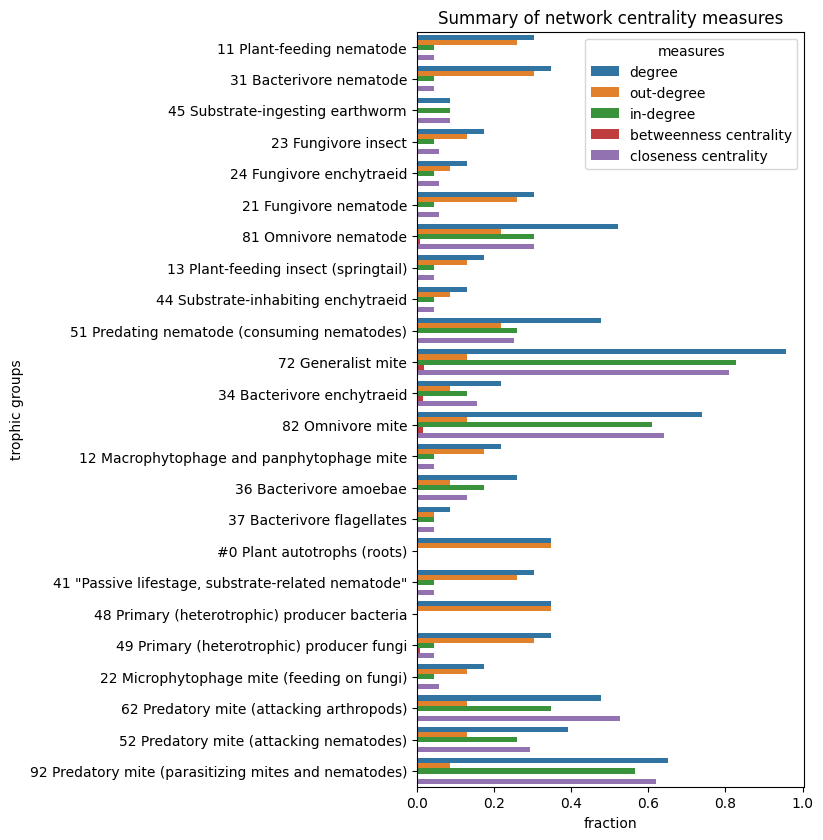

In [332]:
# Convert df_measures to long format
df_meassures_melt = df_measures.reset_index()
df_meassures_melt.rename(columns = {"index" : "trophic groups"}, inplace=True)
df_meassures_melt = df_meassures_melt.melt("trophic groups", var_name='measures', value_name='fraction')
#df_meassures_melt

# barplot of summary table
fig, plot = plt.subplots(figsize=(5, 10), dpi=100)
sns.barplot(x="fraction", y="trophic groups", hue='measures', data=df_meassures_melt)
plot.set_title("Summary of network centrality measures")
plot.figure.savefig("outputs/barplot_cent_measures.png")

In [314]:
# TO-DO: Make button donwload csv of example meassure

## 4.2 Network complexity and connectance

Complexity as the average number of links per species (*Christian needs to confirm and which one to use?)

In [315]:
# Christian complexity
Chr_complex = G.number_of_edges() * G.number_of_nodes()

# Complexity (average number of links per species (Wikipedia())
from statistics import mean
def complexity(g):
    """Calculates the average number of edges (degree) per node in a graph g"""
    deg = g.degree()
    deg_ls = []
    for n, d in deg:
        deg_ls.append(d)
    
    return mean(deg_ls) 

# Connectance
connectance = G.number_of_edges() / (G.number_of_nodes())**2

print(f"Complexity: {complexity(G)}")
print(f"Connectance: {connectance}") 

Complexity: 7.833333333333333
Connectance: 0.16319444444444445


# Part 5: Importing experimental data

## 5.1 Prepare dataset for each plot (?) with avg biomass, mass, abundance of OTU agregated on trophic ID level

In [316]:
# To-do: button to import experimental data

In [317]:
# ***Developer code***
df_field = pd.read_csv("archive/data/RecastingFieldExperiment.txt", sep="\t")

# Correct Trophic_ID column name
df_field.rename(columns={"Trophic_ID ": "Trophic_ID"}, inplace=True)
df_field["Trophic_ID"].value_counts().shape

(24,)

In [318]:
# Create df for Plot A
df_field_a = df_field[df_field["Plot_ID"] == "A"].copy()
# Sort by OTU
df_field_a.sort_values("OTU", inplace=True)

# Add new column with removed log  
df_field_a["Biomass"] = 10**(df_field_a["Log10(Biomass)"])
df_field_a["Mass"] = 10**(df_field_a["Log10(Mass)"])
df_field_a["Abundance"] = 10**(df_field_a["Log10(Abundance)"])

# List of OTUs
OTUs = df_field_a.OTU.unique()
print(f"Number of OTUs in plot A: {len(OTUs)}")

# # Create dictionary for number of times an organism appears (nr. of replicates)
# vc = df_field_a.OTU.value_counts()
# vc = vc.to_dict()

pd.set_option("max_rows", 15)
# df_field_a.Biomass = df_field_a.Biomass
# df_field_a.Mass = df_field_a.Mass
df_field_a

Number of OTUs in plot A: 96


,Record_ID,Plot_ID,Replicate,Web_ID,MajorGroup,PhylogeneticGroup,OTU,Guild,Trophic_ID,Taxon_ID,TrophicLevel,Log10(Abundance),Log10(Mass),Log10(Biomass),TotalSoil-C,TotalSoil-N,TotalSoil-P,Soil-pH,Biomass,Mass,Abundance
132,133,A,1,A1,Mesofauna,Enchytraeidae,Achaeta,Fungivore enchytraeid,24,24001,2,3.15,0.44,3.59,1916.67,173.57,18.86,5.0,3890.451450,2.754229,1412.537545
133,134,A,1,A1,Mesofauna,Enchytraeidae,Achaeta abulba,Fungivore enchytraeid,24,24001,2,3.15,0.77,3.92,1916.67,173.57,18.86,5.0,8317.637711,5.888437,1412.537545
147,148,A,3,A3,Mesofauna,Enchytraeidae,Achaeta abulba,Fungivore enchytraeid,24,24001,2,2.85,0.77,3.62,3083.33,171.43,16.19,4.9,4168.693835,5.888437,707.945784
0,1,A,1,A1,Mesofauna,Acarina,Achipteria coleoptrata,Macrophytophage and panphytophage mite,12,12001,2,2.88,1.31,4.19,1916.67,173.57,18.86,5.0,15488.166189,20.417379,758.577575
2,3,A,2,A2,Mesofauna,Acarina,Achipteria coleoptrata,Macrophytophage and panphytophage mite,12,12001,2,2.88,1.14,4.02,2416.67,167.86,17.60,5.0,10471.285481,13.803843,758.577575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,297,A,1,A1,Microfauna,Nematoda,Tylenchorhynchus dubius,Plant-feeding nematode,11,11163,2,5.28,-0.66,4.62,1916.67,173.57,18.86,5.0,41686.938347,0.218776,190546.071796
329,330,A,2,A2,Microfauna,Nematoda,Tylenchorhynchus dubius,Plant-feeding nematode,11,11163,2,4.65,-0.66,3.99,2416.67,167.86,17.60,5.0,9772.372210,0.218776,44668.359215
368,369,A,3,A3,Microfauna,Nematoda,Tylenchorhynchus dubius,Plant-feeding nematode,11,11163,2,3.94,-0.66,3.28,3083.33,171.43,16.19,4.9,1905.460718,0.218776,8709.635900
18,19,A,3,A3,Mesofauna,Acarina,Tyrophagus,Microphytophage mite (feeding on fungi),22,22140,2,2.88,0.73,3.61,3083.33,171.43,16.19,4.9,4073.802778,5.370318,758.577575
